<a href="https://colab.research.google.com/github/carlibeisel/mason_water_budget/blob/main/water_budget_figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Figures from Mason Water Budget

By: Carli Beisel

Created on August, 2024

Purpose: Create figures for each reach.

In [1]:
## --------------- ##
## IMPORT PACKAGES ##
## --------------- ##

import pandas as pd
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ------------ #
# Custom Colors
# ------------ #

# for Reaches
reach_palette = {
    "Reach 1": "#5CAB7D",
    "Reach 2": "#1D3461",
    "Reach 3": "#F3AF04",
    "Purdum Reach": "#32A0CF",
    "Solomon Reach": "#9D91A3",
    "Noble Reach": "#C64846"
}

# for WB components
wb_palette = {
    'Qin': '#4BA3C3',     # Inflow
    'Precip (AF)': '#21A179',  # Precipitation
    'SR (AF)': '#D58936',      # SR
    'Qout': '#175676',    # Outflow
    'Evap (AF)': '#E46343',     # Evapotranspiration
    'Residual (AF)': 'none'    # Hollow for Residual
}


## Water Budget without Runoff

In [69]:
## ------------------------------ ##
##     IMPORT WATER BUDGET FILE   ##
## ------------------------------ ##

# Without Surface Runoff
file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_norunoff.csv') # no surface runoff

# With Surface Runoff
#file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_af.csv')
file['Month'] = pd.to_datetime(file['Month'], errors='coerce').dt.strftime('%B')


# Abbreviate month names
file['Month'] = file['Month'].map({
    'March': 'MAR', 'April': 'APR', 'May': 'MAY', 'June': 'JUN',
    'July': 'JUL', 'August': 'AUG', 'September': 'SEP', 'October': 'OCT',
    'November': 'NOV', 'December': 'DEC'
})

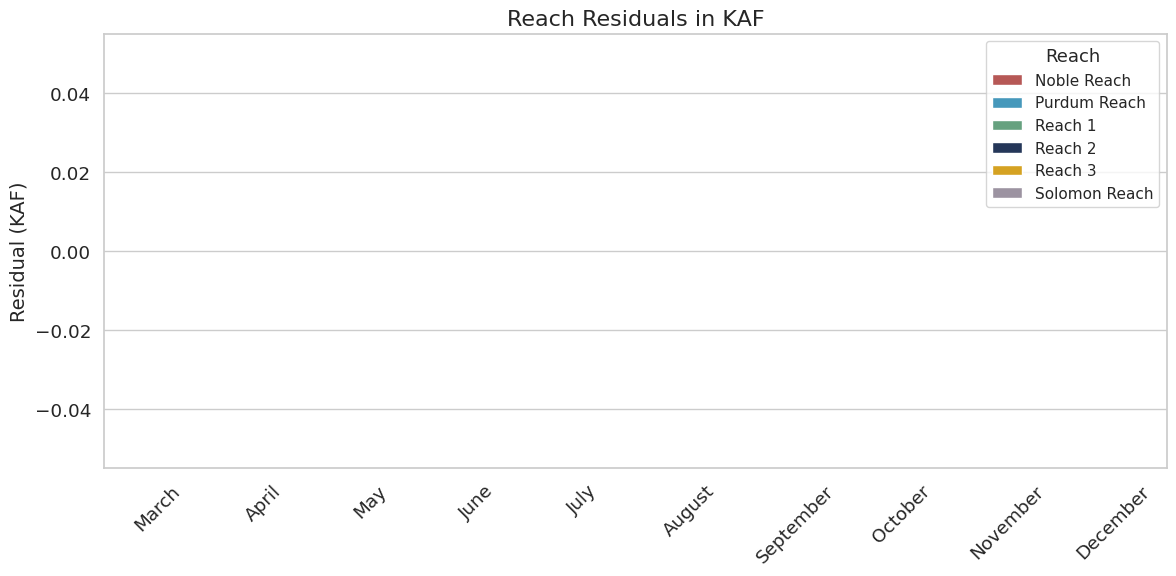

In [65]:
# ---------------- #
# Figure: Residual (KAF)
# ---------------- #

file['Residual (KAF)'] = file['Residual (AF)'] / 1000 #convert to KAF

# Remove rows with NaN values in the new column
file = file.dropna(subset=['Residual (KAF)'])

# Create the bar plot
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=file,
    x='Month', y='Residual (KAF)', hue='Reach',
    palette=reach_palette,
    order=['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
)

# Update plot labels to reflect KAF
plt.title("Reach Residuals in KAF", fontsize=16)
plt.xlabel("")
plt.ylabel("Residual (KAF)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Reach", title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()

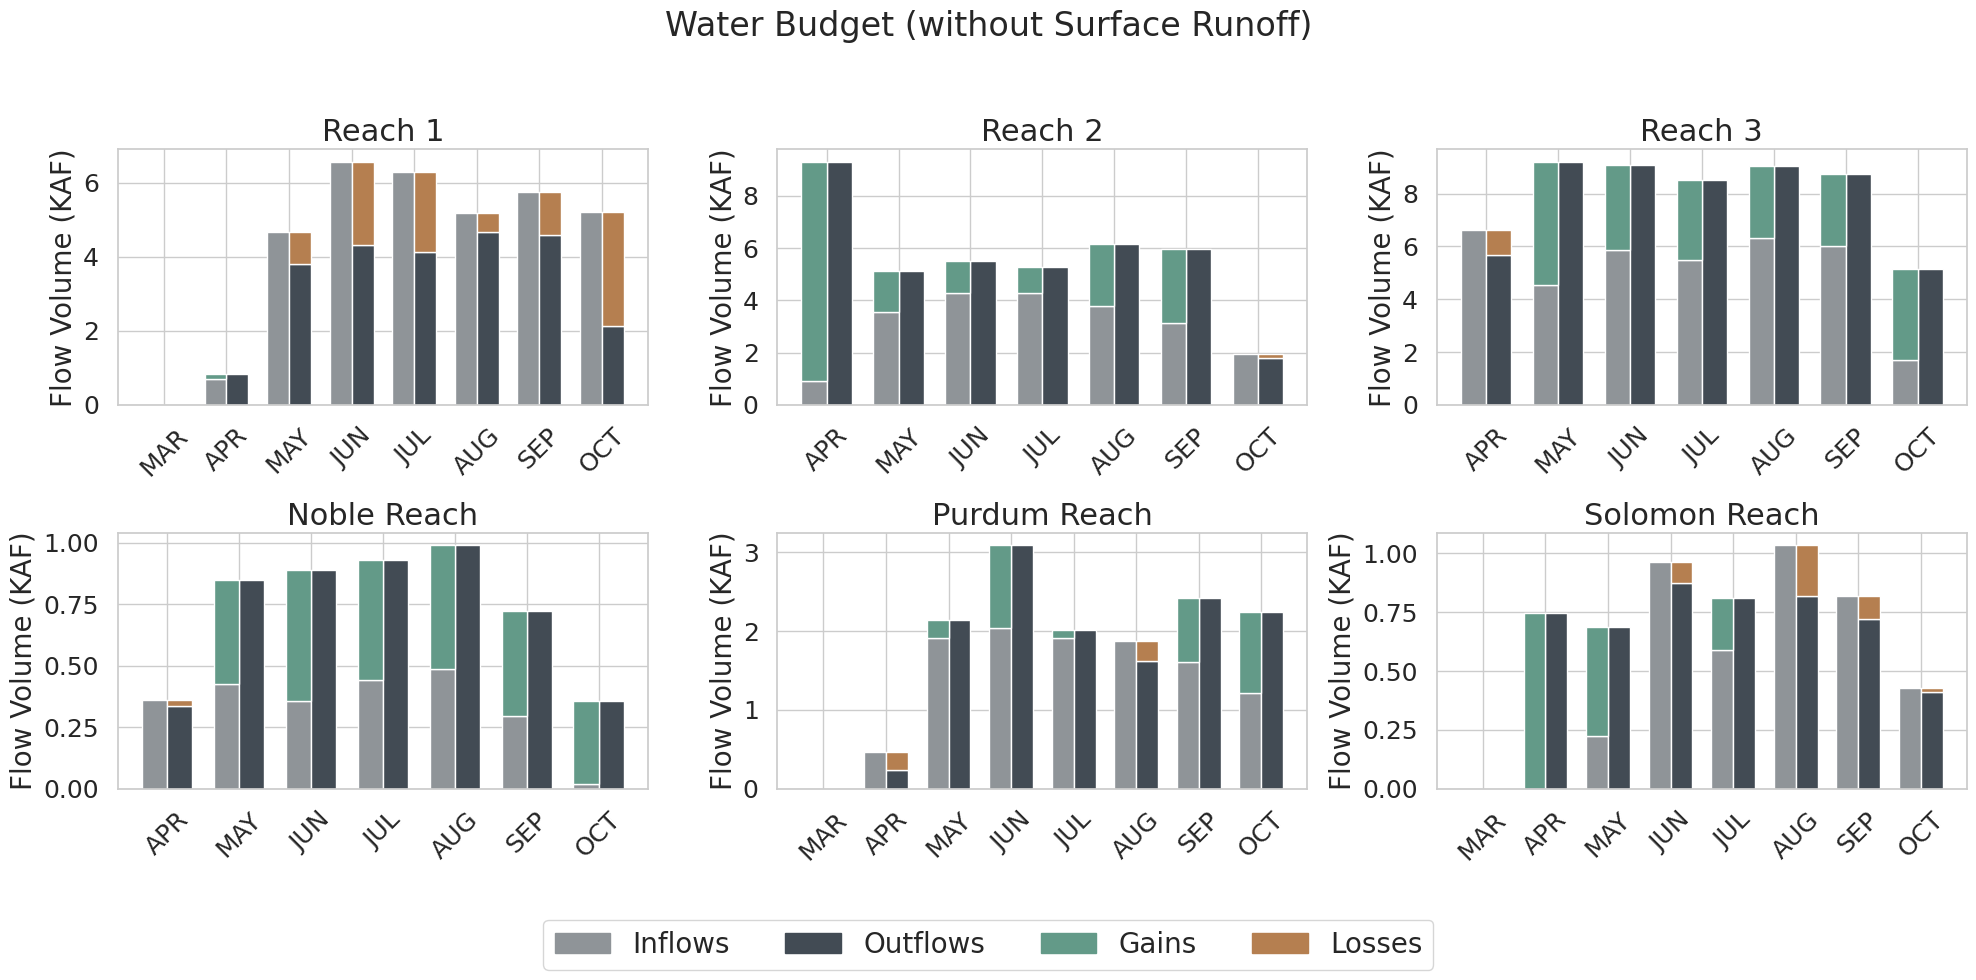

In [66]:
# --------------------- #
# Figure : Inflow/Outflow Comparison
# --------------------- #

# Define custom color palette for inflows, outflows, and residual sides
component_palette = {
    'Inflows': '#8F9498',          # Inflows
    'Outflows': '#424B54',        # Outflows
    'Residual Inflow': '#639A88',  # Residual on inflow side (positive)
    'Residual Outflow': '#B57F50'  # Residual on outflow side (negative)
}

# Data Preparation: Restructure the DataFrame
file['Inflows (KAF)'] = file[['Qin', 'Precip (AF)']].sum(axis=1) / 1000  # Convert to KAF
file['Outflows (KAF)'] = file[['Qout', 'Evap (AF)']].sum(axis=1) / 1000  # Convert to KAF
file['Residual (KAF)'] = file['Residual (AF)'] / 1000  # Convert residuals to KAF

# Ensure the month order and reach order are consistent
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)

# Specify the desired order of reaches
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']

# Filter reaches based on the order and ensure all reaches are present in the dataset
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach and exclude NaN months
    reach_data = file[file['Reach'] == reach].dropna(subset=['Month']).sort_values(by='Month')

    # Skip if no data is available after filtering
    if reach_data.empty:
        continue

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.35  # Width of the bars

    # Plot inflows as positive bars
    ax.bar(
        x - width / 2, reach_data['Inflows (KAF)'], width, color=component_palette['Inflows']
    )

    # Plot outflows as positive bars
    ax.bar(
        x + width / 2, reach_data['Outflows (KAF)'], width, color=component_palette['Outflows']
    )

    # Plot residuals stacked on inflows or outflows
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:  # Positive residual -> inflow
            ax.bar(
                x[i] - width / 2, residual, width,
                bottom=reach_data['Inflows (KAF)'].iloc[i],
                color=component_palette['Residual Inflow']
            )
        elif residual < 0:  # Negative residual -> outflow
            ax.bar(
                x[i] + width / 2, abs(residual), width,
                bottom=reach_data['Outflows (KAF)'].iloc[i],
                color=component_palette['Residual Outflow']
            )

    # Formatting for each subplot
    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, size=18)
    ax.tick_params(axis='y', length=10, width=2, labelsize=18)
    ax.tick_params(axis='x', length=10, width=2, labelsize=18)
    ax.set_title(f"{reach}", fontsize=22)
    ax.set_ylabel("Flow Volume (KAF)", fontsize=20)

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=component_palette['Inflows'], label='Inflows'),
    mpatches.Patch(color=component_palette['Outflows'], label='Outflows'),
    mpatches.Patch(color=component_palette['Residual Inflow'], label='Gains'),
    mpatches.Patch(color=component_palette['Residual Outflow'], label='Losses')
]

fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (without Surface Runoff)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<ipython-input-70-944b04d76d00>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file['Month'] = pd.Categorical(file['Month'], categories=valid_months, ordered=True)


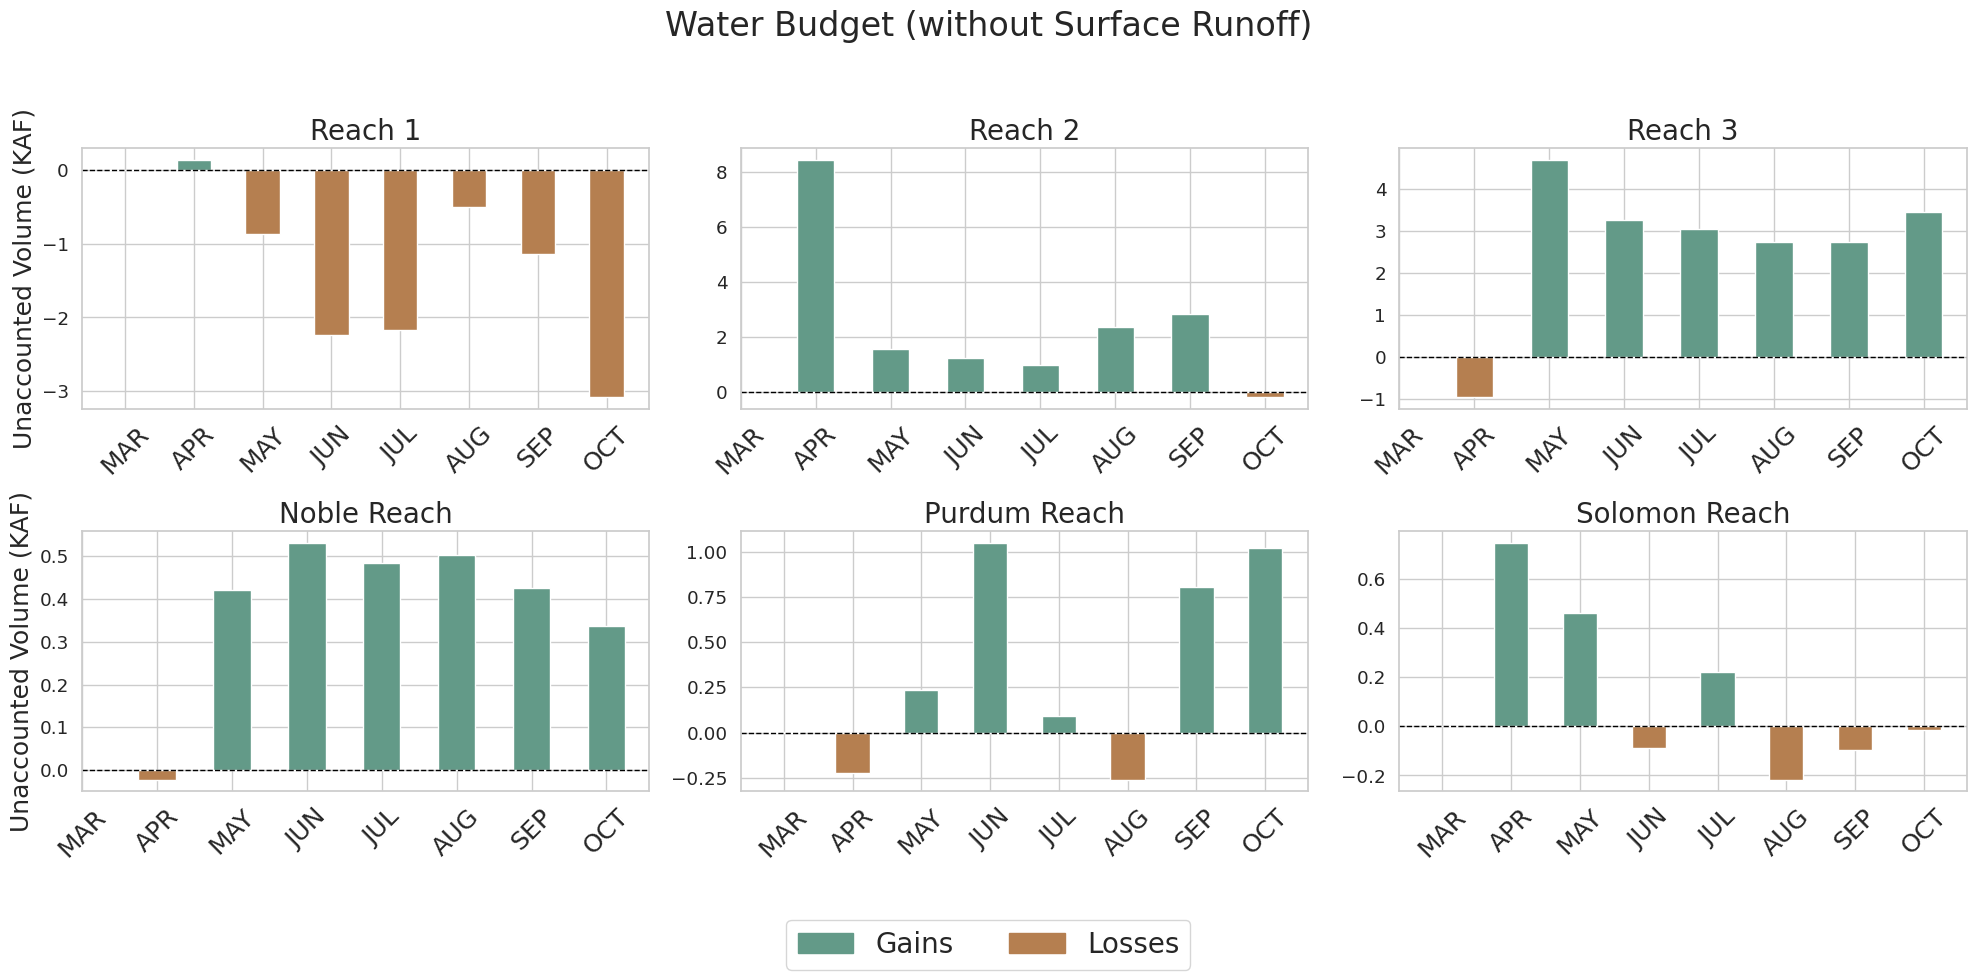

In [70]:
# --------------------- #
# Figure : Unacounted Gains/Losses
# --------------------- #
# Define custom color palette for residuals
residual_palette = {
    'Gains': '#639A88',  # Residual on inflow side (positive)
    'Losses': '#B57F50'  # Residual on outflow side (negative)
}

# Convert residuals to KAF
file['Residual (KAF)'] = file['Residual (AF)'] / 1000

# Filter and sort data for valid months
valid_months = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT']
file = file[file['Month'].isin(valid_months)]
file['Month'] = pd.Categorical(file['Month'], categories=valid_months, ordered=True)

# Specify the desired order of reaches
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']

# Filter reaches based on the order and ensure all reaches are present in the dataset
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Track labels to prevent duplicate entries in the legend
labels_added = {'Positive Residual': False, 'Negative Residual': False}

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.5  # Width of the bars

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:  # Positive residual -> inflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Gains'],
                label='Gains' if not labels_added['Positive Residual'] else None
            )
            labels_added['Positive Residual'] = True
        elif residual < 0:  # Negative residual -> outflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Losses'],
                label='Losses' if not labels_added['Negative Residual'] else None
            )
            labels_added['Negative Residual'] = True

    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)

    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Add a horizontal line at 0
    ax.set_title(f"{reach}", fontsize=20)

    # Only add y-axis labels for leftmost plots
    if idx % cols == 0:
        ax.set_ylabel("Unaccounted Volume (KAF)", fontsize=18)
    else:
        ax.set_ylabel("")  # Clear labels for other plots

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=residual_palette['Gains'], label='Gains'),
    mpatches.Patch(color=residual_palette['Losses'], label='Losses')
]

# Add the legend
fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (without Surface Runoff)", fontsize=24)

# Adjust layout to fit the legend and title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

## Water Budget with Runoff data

In [45]:
## ------------------------------ ##
##     IMPORT WATER BUDGET FILE   ##
## ------------------------------ ##

# With Surface Runoff
file = pd.read_csv('/content/drive/MyDrive/Data/Mason Water Budget/data_output/compiled_data/final_water_budget_af.csv')
file['Month'] = pd.to_datetime(file['Month'], errors='coerce').dt.strftime('%B')
file = file[file['Month'].isin(['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October'])]


# Abbreviate month names
file['Month'] = file['Month'].map({
    'March': 'MAR', 'April': 'APR', 'May': 'MAY', 'June': 'JUN',
    'July': 'JUL', 'August': 'AUG', 'September': 'SEP', 'October': 'OCT',
    'November': 'NOV', 'December': 'DEC'
})

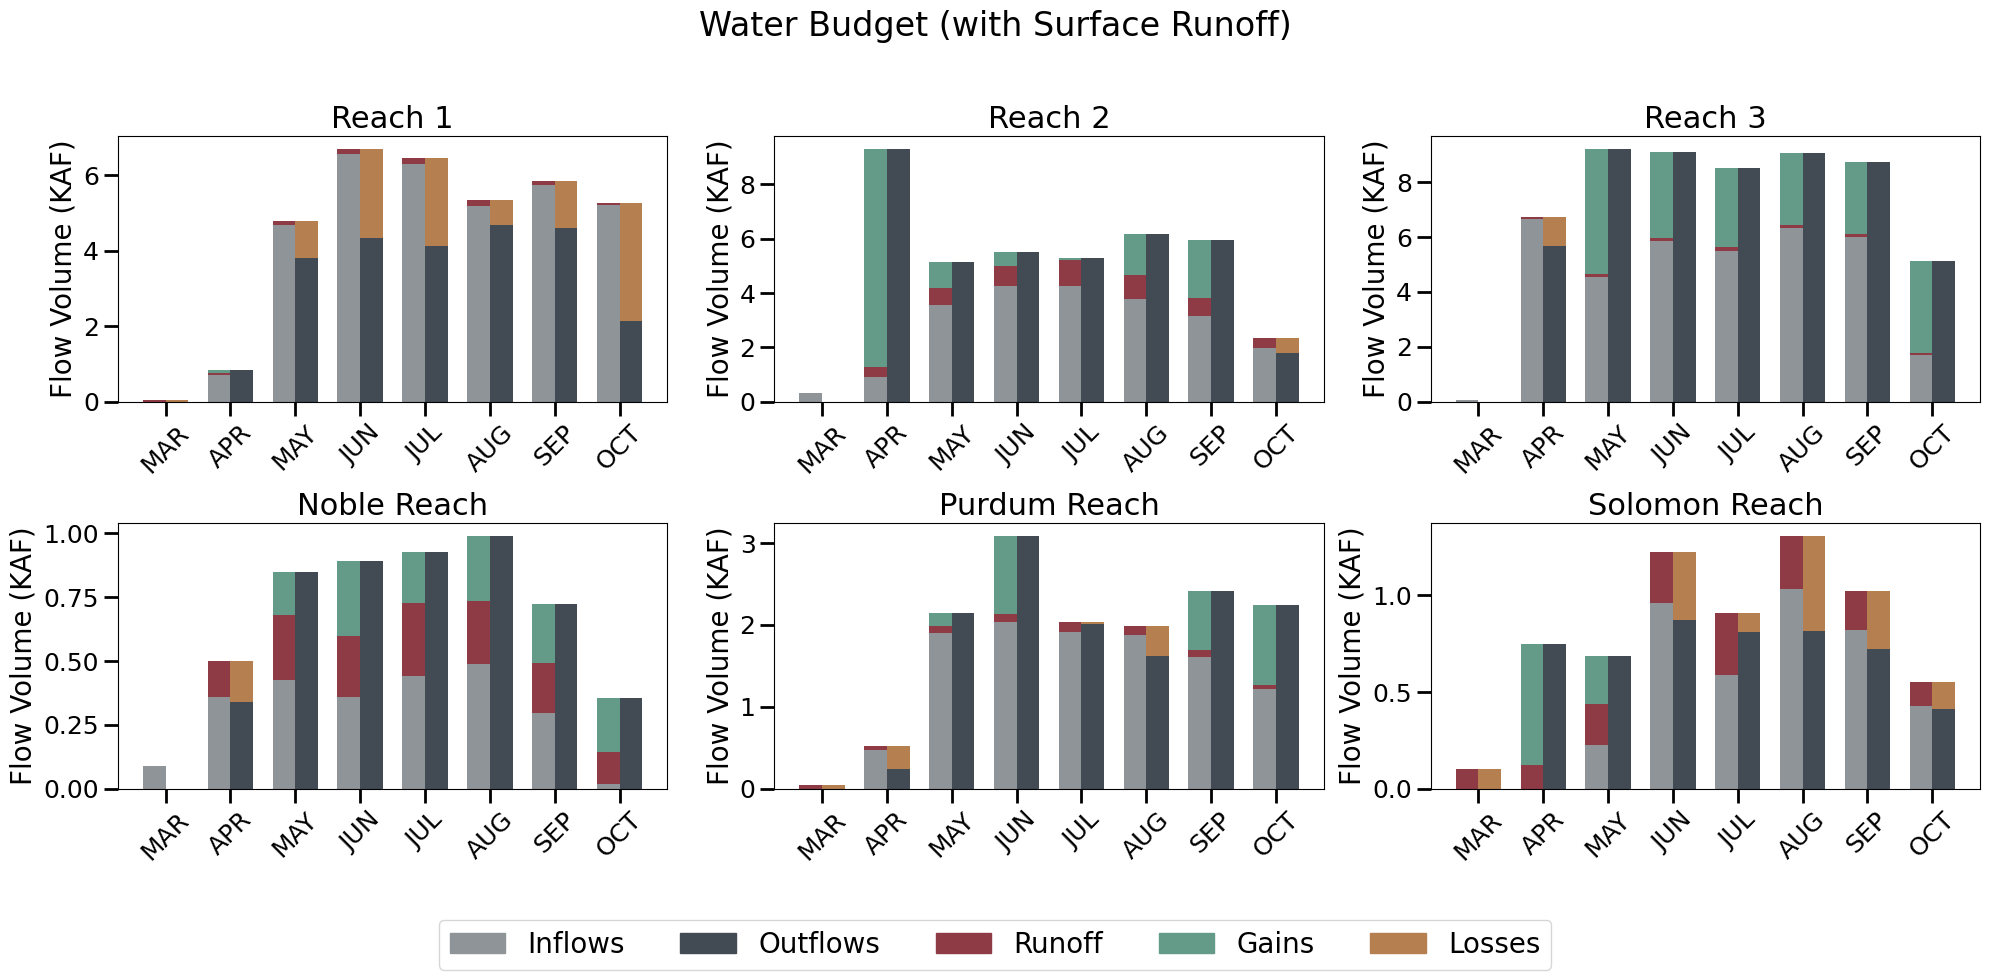

In [44]:
# --------------------- #
# Figure : Water Budget
# --------------------- #

# Define custom color palette for inflows, outflows, and residual sides
component_palette = {
    'Inflows': '#8F9498',          # Inflows
    'Outflows': '#424B54',        # Outflows
    'Residual Inflow': '#639A88',  # Residual on inflow side (positive)
    'Residual Outflow': '#B57F50', # Residual on outflow side (negative)
    'SR': '#8E3B46'               # SR component (Surface Runoff)
}


# Convert all flow values to KAF (thousands of acre-feet)
file['Inflows (KAF)'] = file[['Qin', 'Precip (AF)', 'SR (AF)']].sum(axis=1) / 1000
file['Outflows (KAF)'] = file[['Qout', 'Evap (AF)']].sum(axis=1) / 1000
file['Qin (KAF)'] = file['Qin'] / 1000
file['Precip (KAF)'] = file['Precip (AF)'] / 1000
file['SR (KAF)'] = file['SR (AF)'] / 1000
file['Qout (KAF)'] = file['Qout'] / 1000
file['Evap (KAF)'] = file['Evap (AF)'] / 1000
file['Residual (KAF)'] = file['Residual (AF)'] / 1000

# Specify month and reach orders
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break

    ax = axes[idx]
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')
    x = np.arange(len(reach_data['Month']))
    width = 0.35

    # Plot inflows
    ax.bar(x - width / 2, reach_data['Inflows (KAF)'], width, color=component_palette['Inflows'])

    # Plot SR
    ax.bar(x - width / 2, reach_data['SR (KAF)'], width,
           bottom=reach_data['Qin (KAF)'] + reach_data['Precip (KAF)'],
           color=component_palette['SR'])

    # Plot outflows
    ax.bar(x + width / 2, reach_data['Outflows (KAF)'], width, color=component_palette['Outflows'])

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:
            ax.bar(x[i] - width / 2, residual, width,
                   bottom=reach_data['Inflows (KAF)'].iloc[i],
                   color=component_palette['Residual Inflow'])
        elif residual < 0:
            ax.bar(x[i] + width / 2, abs(residual), width,
                   bottom=reach_data['Outflows (KAF)'].iloc[i],
                   color=component_palette['Residual Outflow'])

    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)
    ax.set_title(f"{reach}", fontsize=22)
    ax.set_ylabel("Flow Volume (KAF)", fontsize=20)
    ax.tick_params(axis='y', length=10, width=2, labelsize=18)
    ax.tick_params(axis='x', length=10, width=2, labelsize=18)

# Remove extra subplots
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=component_palette['Inflows'], label='Inflows'),
    mpatches.Patch(color=component_palette['Outflows'], label='Outflows'),
    mpatches.Patch(color=component_palette['SR'], label='Runoff'),
    mpatches.Patch(color=component_palette['Residual Inflow'], label='Gains'),
    mpatches.Patch(color=component_palette['Residual Outflow'], label='Losses')
]


fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (with Surface Runoff)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

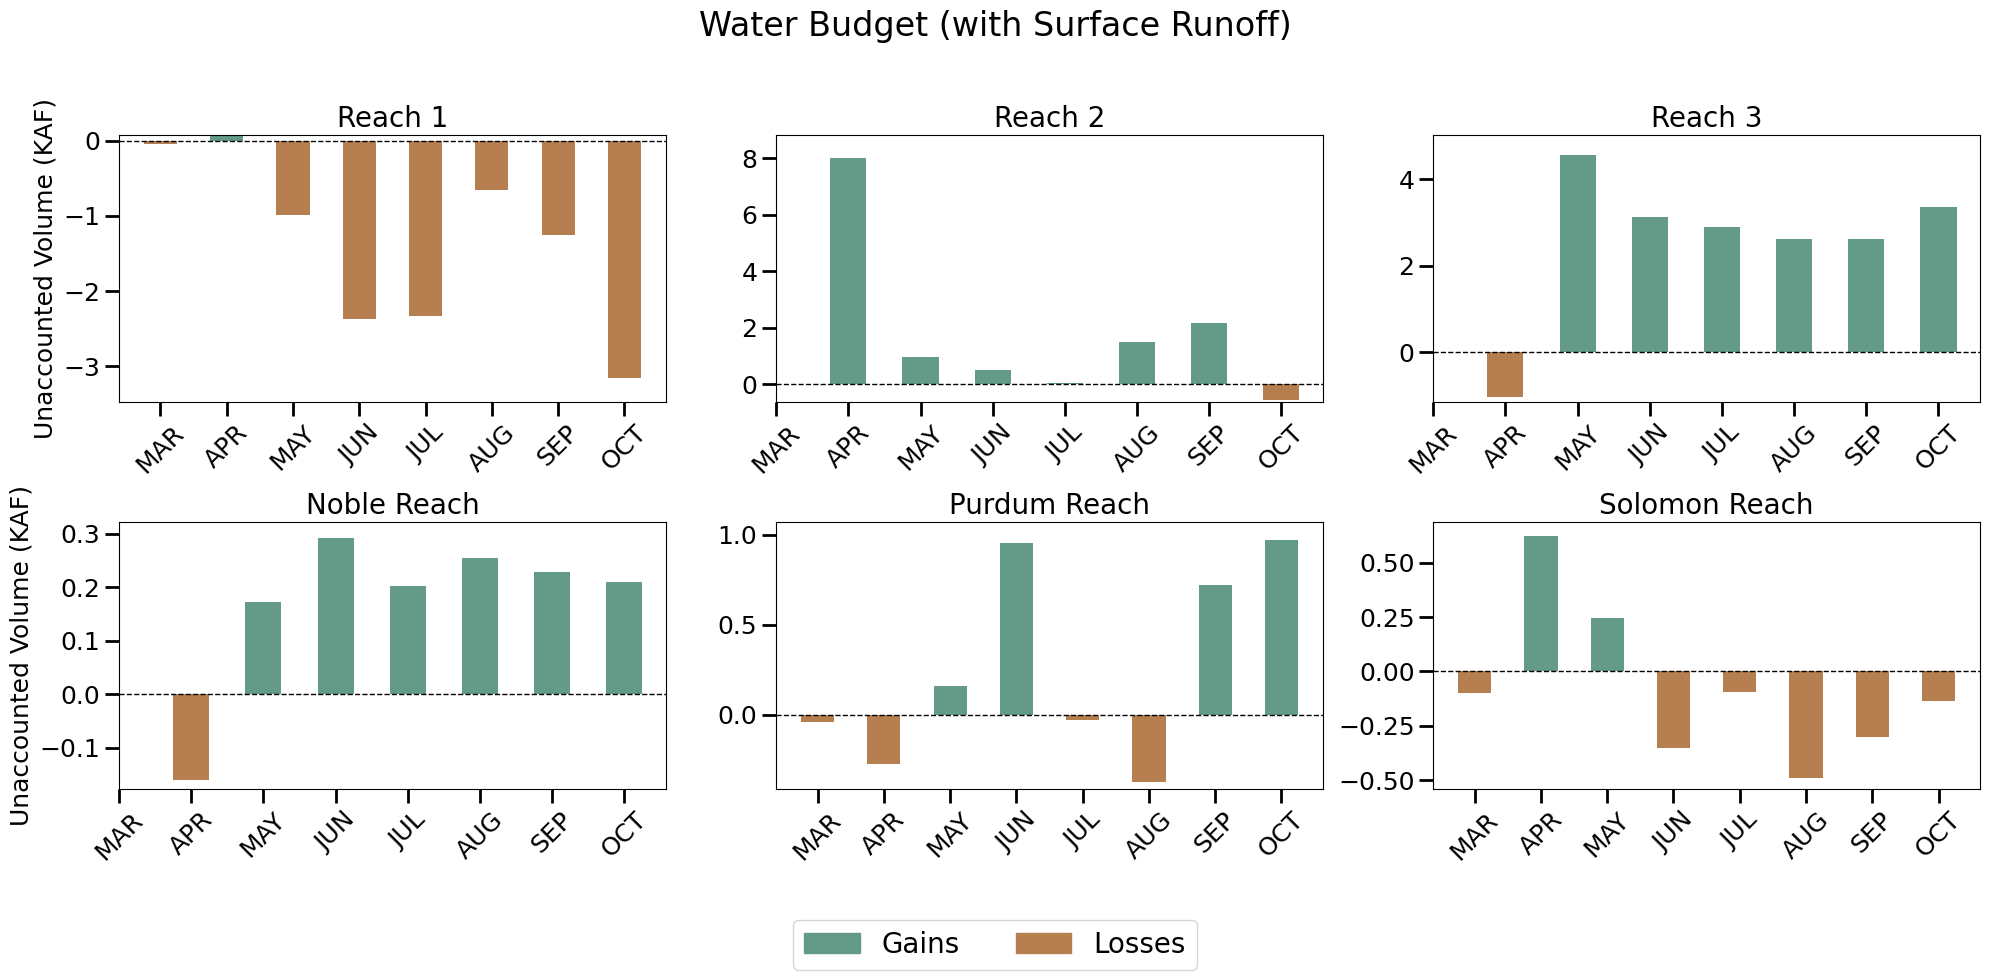

<Figure size 640x480 with 0 Axes>

In [54]:
# --------------------- #
# Figure : Unacounted Gains/Losses
# --------------------- #

# Define custom color palette for residuals
residual_palette = {
    'Gains': '#639A88',  # Residual on inflow side (positive)
    'Losses': '#B57F50'  # Residual on outflow side (negative)
}

# Convert residuals to KAF
file['Residual (KAF)'] = file['Residual (AF)'] / 1000

# Ensure the month order and reach order are consistent
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Track labels to prevent duplicate entries in the legend
labels_added = {'Positive Residual': False, 'Negative Residual': False}

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.5  # Width of the bars

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:  # Positive residual -> inflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Gains'],
                label='Gains' if not labels_added['Positive Residual'] else None
            )
            labels_added['Positive Residual'] = True
        elif residual < 0:  # Negative residual -> outflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Losses'],
                label='Losses' if not labels_added['Negative Residual'] else None
            )
            labels_added['Negative Residual'] = True

    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)

    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Add a horizontal line at 0
    ax.set_title(f"{reach}", fontsize=20)
    ax.tick_params(axis='y', length=10, width=2, labelsize=18)
    ax.tick_params(axis='x', length=10, width=2, labelsize=18)

    # Set dynamic y-axis limits based on the reach data
    reach_min = reach_data['Residual (KAF)'].min()
    reach_max = reach_data['Residual (KAF)'].max()
    ax.set_ylim(reach_min - abs(reach_min) * 0.1, reach_max + abs(reach_max) * 0.1)

    # Only add y-axis labels for leftmost plots
    if idx % cols == 0:
        ax.set_ylabel("Unaccounted Volume (KAF)", fontsize=18)
    else:
        ax.set_ylabel("")  # Clear labels for other plots

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=residual_palette['Gains'], label='Gains'),
    mpatches.Patch(color=residual_palette['Losses'], label='Losses')
]


fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (with Surface Runoff)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()

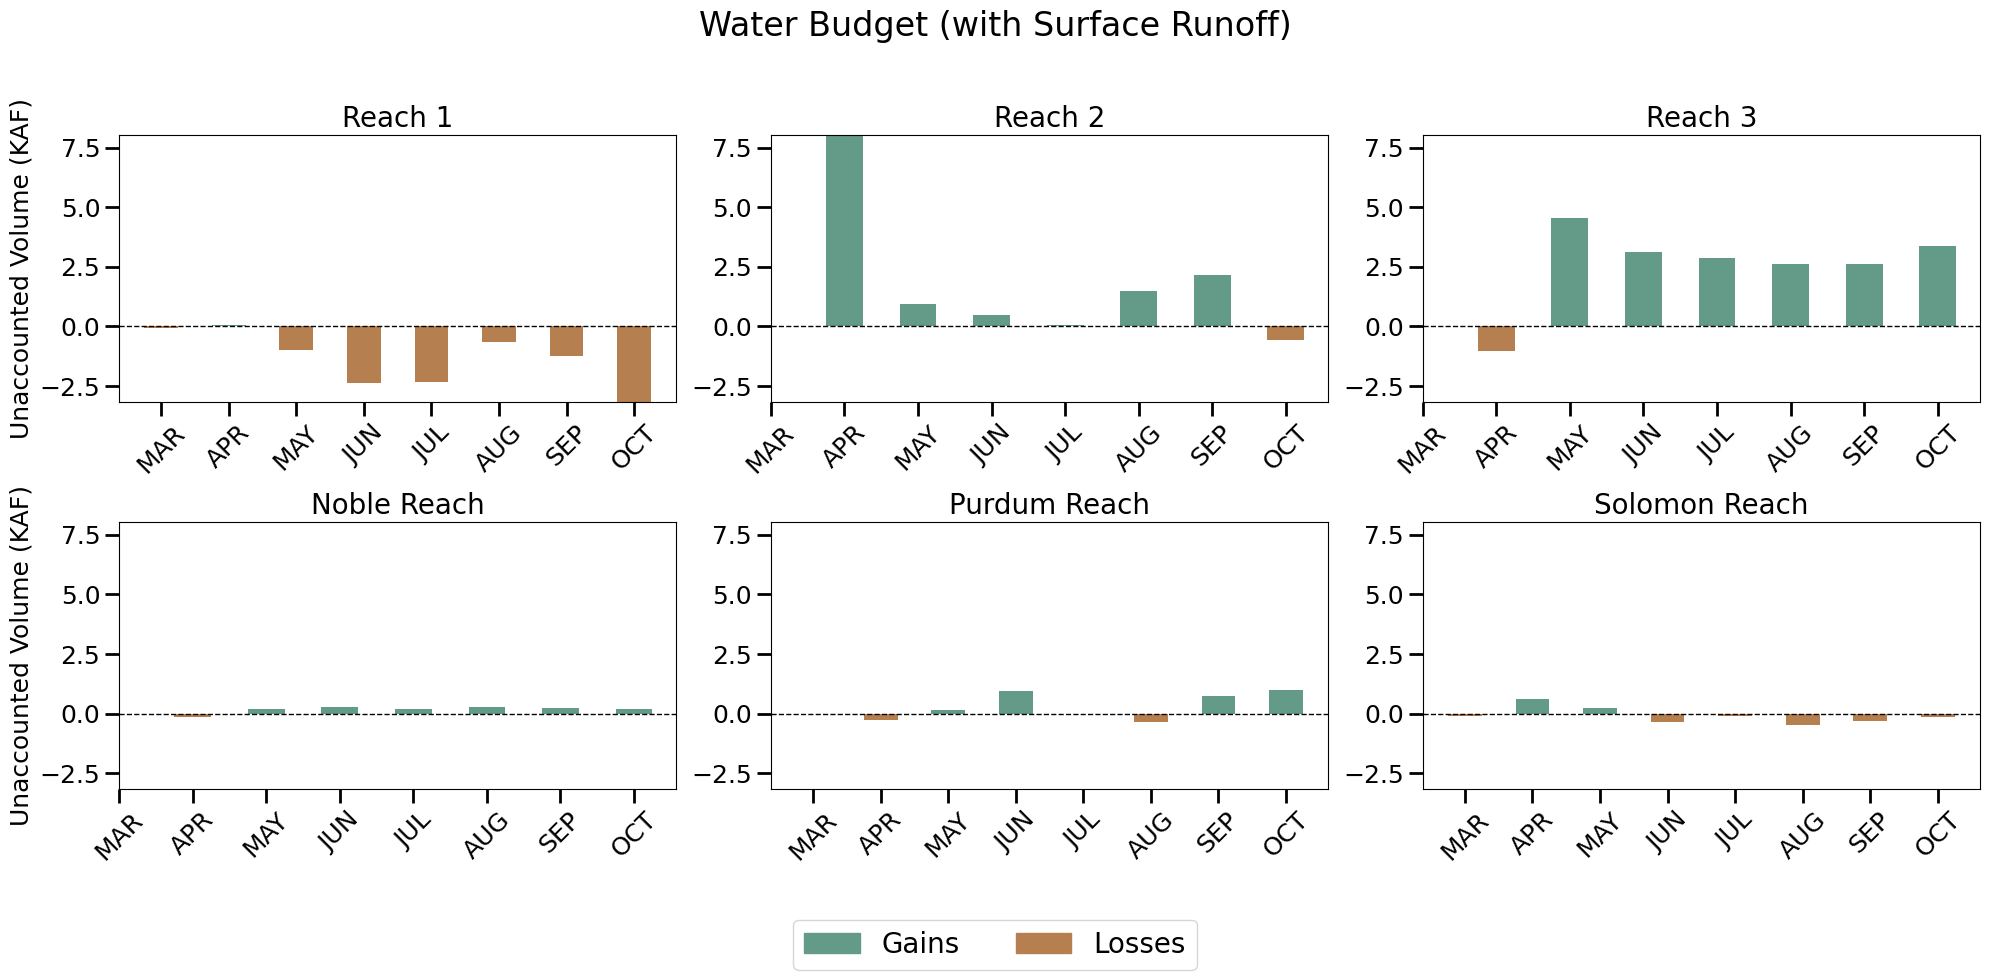

<Figure size 640x480 with 0 Axes>

In [52]:
# --------------------- #
# Figure : Unacounted Gains/Losses
# --------------------- #
# same scale for all

# Define custom color palette for residuals
residual_palette = {
    'Gains': '#639A88',  # Residual on inflow side (positive)
    'Losses': '#B57F50'  # Residual on outflow side (negative)
}

# Convert residuals to KAF
file['Residual (KAF)'] = file['Residual (AF)'] / 1000

# Ensure the month order and reach order are consistent
months_order = ['MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
file['Month'] = pd.Categorical(file['Month'], categories=months_order, ordered=True)
reach_order = ['Reach 1', 'Reach 2', 'Reach 3', 'Noble Reach', 'Purdum Reach', 'Solomon Reach']
reaches = [reach for reach in reach_order if reach in file['Reach'].unique()]

# Set up the grid
rows, cols = 4, 3  # Define grid dimensions
fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Track labels to prevent duplicate entries in the legend
labels_added = {'Positive Residual': False, 'Negative Residual': False}

# Determine a common y-axis range
all_residuals = file['Residual (KAF)']
y_min, y_max = all_residuals.min(), all_residuals.max()

# Loop through each reach and plot
for idx, reach in enumerate(reaches):
    if idx >= len(axes):
        break  # Prevent indexing errors if there are fewer reaches than plots

    ax = axes[idx]

    # Filter data for the current reach
    reach_data = file[file['Reach'] == reach].sort_values(by='Month')

    # Set up the x-axis positions
    x = np.arange(len(reach_data['Month']))  # Numeric x-axis positions
    width = 0.5  # Width of the bars

    # Plot residuals
    for i, residual in enumerate(reach_data['Residual (KAF)']):
        if residual > 0:  # Positive residual -> inflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Gains'],
                label='Gains' if not labels_added['Positive Residual'] else None
            )
            labels_added['Positive Residual'] = True
        elif residual < 0:  # Negative residual -> outflow side
            ax.bar(
                x[i], residual, width,
                color=residual_palette['Losses'],
                label='Losses' if not labels_added['Negative Residual'] else None
            )
            labels_added['Negative Residual'] = True

    ax.set_xticks(x)
    ax.set_xticklabels(reach_data['Month'], rotation=45, fontsize=18)

    ax.axhline(0, color='black', linewidth=1, linestyle='--')  # Add a horizontal line at 0
    ax.set_title(f"{reach}", fontsize=20)
    ax.tick_params(axis='y', length=10, width=2, labelsize=18)
    ax.tick_params(axis='x', length=10, width=2, labelsize=18)

    # Set consistent y-axis limits
    ax.set_ylim(y_min, y_max)

    # Only add y-axis labels for leftmost plots
    if idx % cols == 0:
        ax.set_ylabel("Unaccounted Volume (KAF)", fontsize=18)
    else:
        ax.set_ylabel("")  # Clear labels for other plots

# Remove empty subplots if any
for idx in range(len(reaches), len(axes)):
    fig.delaxes(axes[idx])

# Define custom legend handles
legend_handles = [
    mpatches.Patch(color=residual_palette['Gains'], label='Gains'),
    mpatches.Patch(color=residual_palette['Losses'], label='Losses')
]

fig.legend(handles=legend_handles, loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 0.42))
fig.suptitle("Water Budget (with Surface Runoff)", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the legend
plt.show()